In [4]:
import sys
import os

import pandas as pd
import numpy as np
import natsort
import random as rn
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
import pyeeg

from scipy import signal
from scipy.signal import (welch, medfilt, wiener,savgol_filter)
from scipy.integrate import simps

import matplotlib.pyplot as plt

#Keras

#Sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPRegressor
from sklearn.svm import (SVC, SVR)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import (StratifiedKFold, KFold)

from sklearn.metrics import (accuracy_score, make_scorer, balanced_accuracy_score, roc_auc_score, mean_squared_error)

from sklearn.model_selection import GridSearchCV

from sklearn.manifold import TSNE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional

from sys import getsizeof

seed=42
np.random.seed(seed)
rn.seed(seed)
tf.set_random_seed(seed)
dir_path = os.getcwd()
# https://en.wikipedia.org/wiki/Neural_oscillation
SAMPLE_PER_SEC = 128
SAMPLE_PER_RAT = 21600
DELTA_WAVE = [1, 4]
THETA_WAVE = [4, 8]
ALPHA_WAVE = [7.5, 12.5]
BETA_WAVE = [13, 30]
TOTAL_ENERGY = [0, 64]
# not used
LOW_GAMMA_WAVE = [30, 70]
HIGH_GAMMA_WAVE = [70, 150]

EPSILON =  0.0002
FILTER_WINDOW = 5

In [2]:
from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss
def check_for_floats(Array):
    for row in Array:
        for el in row:
            if isinstance(el, float):
                print(el)
                
def from_label_to_vec(labels):
    labels_vec = []
    for l in labels:
        if l == 1:
            labels_vec.append([1,0,0])
        elif l == 2:
            labels_vec.append([0,1,0])
        elif l == 3:
            labels_vec.append([0,0,1])
    return np.array(labels_vec)

                
def from_vec_to_labels(vecs):
    labels = []
    for v in vecs:
        if v[0] == 1:
            labels.append(1)
        elif v[1] == 1:
            labels.append(2)
        elif v[2] == 1:
            labels.append(3)
    return labels
  
def count_labels(labels):
    classes_cnt = [0,0,0]
    for l in labels:
        classes_cnt[l-1]+=1
    print(classes_cnt)

In [5]:
# LOAD THE FEATURES FROM CSV
X_train = pd.read_csv("features/all_combined_train.csv").values
y_train = np.ravel(pd.read_csv("features/all_combined_label.csv").values)
X_test = pd.read_csv("features/all_combined_test.csv").values

print("X train final shape -> ",X_train.shape)
print("X test final shape -> ",X_test.shape)
#Fit scaler on all data
X_total = np.concatenate((X_train, X_test))
print("X total shape -> ", X_total.shape)

scaler = StandardScaler().fit(X_total)

data_dim = X_train.shape[1]
timesteps = SAMPLE_PER_RAT
num_classes = 3
batch_size = 32


X train final shape ->  (64800, 49)
X test final shape ->  (43200, 49)
X total shape ->  (108000, 49)
112


In [7]:
print(getsizeof(np.array(X_train)))

25401712


NameError: name 'X_trai' is not defined

In [15]:
# CROSS VALDATION
kfold = KFold(n_splits=3, shuffle=False, random_state=seed)

print("Start")
EPOCHS=20
classes = np.array([1,2,3])
weights = compute_class_weight("balanced", classes, y_train)
cw = dict(zip(np.array([0,1,2]), weights))

clf_scores_avg = []
clf_scores_std = []
models = []
bmac_scores = []
for train, valid in kfold.split(X_train):
    # get the folds
    X_train_fold = X_train[train]
    y_train_fold = y_train[train]
    
    X_valid_fold = X_train[valid]
    y_valid_fold = y_train[valid]

    X_train_fold_scaled = scaler.transform(X_train_fold)
    X_valid_fold_scaled = scaler.transform(X_valid_fold)
    
    
    
    ### TRANSFORM FOR LSTM 
    X_train_fold_scaled = np.reshape(X_train_fold_scaled, (2 * timesteps, 1, data_dim))
    y_train_fold = from_label_to_vec(y_train_fold)
    # y_train_fold = np.reshape(y_train_fold, (2 * timesteps, num_classes))
    
    X_valid_fold_scaled = np.reshape(X_valid_fold_scaled, (timesteps, 1, data_dim))
    y_valid_fold = from_label_to_vec(y_valid_fold)
  

    # fit classifier
    # Expected input batch shape: (batch_size, timesteps, data_dim)
    # Note that we have to provide the full batch_input_shape since the network is stateful.
    # the sample of index i in batch k is the follow-up for the sample i in batch k-1.
    model = Sequential()
    #model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False, stateful=True, batch_input_shape=(batch_size, 1, data_dim)))
    model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, stateful=True, batch_input_shape=(batch_size, 1, data_dim)))
    model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, stateful=True))
    model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2, stateful=True))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=weighted_categorical_crossentropy(weights),
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    model.fit(X_train_fold_scaled, y_train_fold,
              class_weight=cw,
              verbose=False,
              batch_size=batch_size, epochs=EPOCHS, shuffle=False,
              validation_data=(X_valid_fold_scaled, y_valid_fold))
    
    models.append(model)
    
    y_pred = model.predict(X_valid_fold_scaled)
    labels = []
    for p in y_pred:
        labels.append(np.argmax(p)+1)
    labels = np.array(labels)

    #remove impossible 
    #y_pred = remove_impossible_transitions(y_pred)
    # median filter
    labels = medfilt(labels, FILTER_WINDOW)


    bmac_score_rf = balanced_accuracy_score(y_train[valid], labels)
    print(f"{len(bmac_scores)}: current balanced_accuracy_score: {bmac_score_rf}")

    bmac_scores.append(bmac_score_rf)
    
clf_scores_avg.append(np.mean(bmac_scores))
clf_scores_std.append(np.std(bmac_scores))

print("================================================================================")

print(f"LSTM BMAC avg score {clf_scores_avg[0]} +/- {clf_scores_std[0]}" )

print("================================================================================")
print("================================================================================")

print("DEFAULT 0.924203064567119 +/- 0.026768125976249342")
print("GAMMA = 0.0004 0.9401296487697763 +/- 0.02925282597198205")
print("GAMMA = 0.0004 C=0.1 0.9434637293201353 +/- 0.0257096513820207")
print("GAMMA = 0.0004 C=0.01 0.930809065681996 +/- 0.022307773367821106")
print("LSTM BMAC avg score 0.9237825755034632 +/- 0.029030537234862867")

Start
0: current balanced_accuracy_score: 0.8924409426792832
1: current balanced_accuracy_score: 0.9487431446137857
2: current balanced_accuracy_score: 0.9365146530176931
LSTM BMAC avg score 0.9258995801035873 +/- 0.024179803078839875
DEFAULT 0.924203064567119 +/- 0.026768125976249342
GAMMA = 0.0004 0.9401296487697763 +/- 0.02925282597198205
GAMMA = 0.0004 C=0.1 0.9434637293201353 +/- 0.0257096513820207
GAMMA = 0.0004 C=0.01 0.930809065681996 +/- 0.022307773367821106
LSTM BMAC avg score 0.9237825755034632 +/- 0.029030537234862867


In [ ]:
# CROSS VALDATION
kfold = KFold(n_splits=3, shuffle=False, random_state=seed)

print("Start")
EPOCHS=500
classes = np.array([1,2,3])
weights = compute_class_weight("balanced", classes, y_train)
cw = dict(zip(np.array([0,1,2]), weights))

clf_scores_avg = []
clf_scores_std = []
models = []
bmac_scores = []
for train, valid in kfold.split(X_train):
    # get the folds
    X_train_fold = X_train[train]
    y_train_fold = y_train[train]
    
    X_valid_fold = X_train[valid]
    y_valid_fold = y_train[valid]

    X_train_fold_scaled = scaler.transform(X_train_fold)
    X_valid_fold_scaled = scaler.transform(X_valid_fold)
    
    
    
    ### TRANSFORM FOR LSTM 
    X_train_fold_scaled = np.reshape(X_train_fold_scaled, (2 * timesteps, 1, data_dim))
    y_train_fold = from_label_to_vec(y_train_fold)
    # y_train_fold = np.reshape(y_train_fold, (2 * timesteps, num_classes))
    
    X_valid_fold_scaled = np.reshape(X_valid_fold_scaled, (timesteps, 1, data_dim))
    y_valid_fold = from_label_to_vec(y_valid_fold)
  
    

    # fit classifier
    # Expected input batch shape: (batch_size, timesteps, data_dim)
    # Note that we have to provide the full batch_input_shape since the network is stateful.
    # the sample of index i in batch k is the follow-up for the sample i in batch k-1.
    model = Sequential()
    model.add(LSTM(1, return_sequences=False, stateful=True, batch_input_shape=(batch_size, 1, data_dim)))
    # model.add(LSTM(32, return_sequences=True, stateful=True, batch_input_shape=(batch_size, 1, data_dim)))
    #model.add(LSTM(32, return_sequences=True, stateful=True))
    #model.add(LSTM(32, stateful=True))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=weighted_categorical_crossentropy(weights),
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    model.fit(X_train_fold_scaled, y_train_fold,
              class_weight=cw,
              verbose=True,
              batch_size=batch_size, epochs=EPOCHS, shuffle=False,
              validation_data=(X_valid_fold_scaled, y_valid_fold))
    
    models.append(model)
    
    y_pred = model.predict(X_valid_fold_scaled)
    labels = []
    for p in y_pred:
        labels.append(np.argmax(p)+1)
    labels = np.array(labels)

    #remove impossible 
    #y_pred = remove_impossible_transitions(y_pred)
    # median filter
    labels = medfilt(labels, FILTER_WINDOW)


    bmac_score_rf = balanced_accuracy_score(y_train[valid], labels)
    print(f"{len(bmac_scores)}: current balanced_accuracy_score: {bmac_score_rf}")

    bmac_scores.append(bmac_score_rf)
    
clf_scores_avg.append(np.mean(bmac_scores))
clf_scores_std.append(np.std(bmac_scores))

print("================================================================================")

print(f"LSTM BMAC avg score {clf_scores_avg[0]} +/- {clf_scores_std[0]}" )

print("================================================================================")
print("================================================================================")

print("DEFAULT 0.924203064567119 +/- 0.026768125976249342")
print("GAMMA = 0.0004 0.9401296487697763 +/- 0.02925282597198205")
print("GAMMA = 0.0004 C=0.1 0.9434637293201353 +/- 0.0257096513820207")
print("GAMMA = 0.0004 C=0.01 0.930809065681996 +/- 0.022307773367821106")
print("LSTM BMAC avg score 0.9237825755034632 +/- 0.029030537234862867")

Start
Train on 43200 samples, validate on 21600 samples
Epoch 1/500
43200/43200 [==============================] - 13s 309us/step - loss: 2.1471 - acc: 0.4668 - val_loss: 1.0841 - val_acc: 0.5158
Epoch 2/500
43200/43200 [==============================] - 10s 234us/step - loss: 2.0240 - acc: 0.5363 - val_loss: 1.0552 - val_acc: 0.5077
Epoch 3/500
43200/43200 [==============================] - 10s 241us/step - loss: 1.9839 - acc: 0.5543 - val_loss: 1.0307 - val_acc: 0.5315
Epoch 4/500
43200/43200 [==============================] - 10s 240us/step - loss: 1.9260 - acc: 0.6218 - val_loss: 0.9823 - val_acc: 0.7104
Epoch 5/500
43200/43200 [==============================] - 10s 230us/step - loss: 1.8161 - acc: 0.7818 - val_loss: 0.9075 - val_acc: 0.8056
Epoch 6/500
43200/43200 [==============================] - 10s 235us/step - loss: 1.7113 - acc: 0.8561 - val_loss: 0.8504 - val_acc: 0.8144
Epoch 7/500
43200/43200 [==============================] - 10s 240us/step - loss: 1.6057 - acc: 0.8597 -

In [16]:
#Scale, fit, predict
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
y_pred = np.zeros((X_test_scaled.shape[0], 3))

# predict with all
for model in models:
    y_pred += model.predict(np.reshape(X_test_scaled, (2 * timesteps, 1, data_dim)))
    
# compute avg
y_pred /= 3.0

y_pred_filtered = []
for p in y_pred:
    y_pred_filtered.append(np.argmax(p)+1)
y_pred_filtered = np.array(y_pred_filtered)


# CORRECT all  predictions 1 to 3
#y_pred_filtered = remove_impossible_transitions(y_pred_filtered)

#  medfilt, wiener,savgol_filter
y_pred_filtered = medfilt(y_pred_filtered, FILTER_WINDOW)

Class 1: 18503
Class 2: 22532
Class 3: 2165


'\nClass 1: 23933\nClass 2: 18553\nClass 3: 714\n'

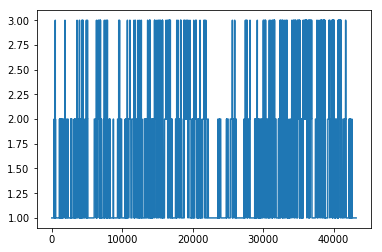

In [18]:
submission_name = "ax_LSTM_avg_dropout.csv"

print(f"Class 1: {np.sum(y_pred_filtered == 1)}")
print(f"Class 2: {np.sum(y_pred_filtered == 2)}")
print(f"Class 3: {np.sum(y_pred_filtered == 3)}")

y_pred_df = pd.DataFrame(y_pred_filtered)
y_pred_df = y_pred_df.assign(Id=list(range(y_pred_filtered.shape[0])))
y_pred_df.columns = ['y', 'Id']
y_pred_df["y"].plot()
submission_folder = os.path.join(dir_path,"submissions/")
csv_file = submission_folder + submission_name

with open(csv_file, 'w') as csv:
    y_pred_df.to_csv(csv,index = False)
"""
Class 1: 23933
Class 2: 18553
Class 3: 714
"""